# IMPORTS

In [3]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from sklearn.utils import shuffle
import torch
from NoteBookUtilities.read_data import get_seq_indexes
from pathlib import Path
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import random

### SETTING SEEDS ###
random.seed(10)
np.random.seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "Data"  
BEPIPRED2_DATA = ROOT_DIR / "Data" / "BepiPred2Data"
BEPIPRED3_DATA = ROOT_DIR / "Data" / "BepiPred3Data"
#DATASET_DIR = DATA_DIR / "Datasets"

RESULTS_DIR = ROOT_DIR / "Results"
RANDOM_FOREST_CLASSIFICATION = RESULTS_DIR / "RandomForestClassification"
FIGURE_DIR = RANDOM_FOREST_CLASSIFICATION / "Figures"

###BLOSUM ENCODING ###
blosum_encode_dict = {"A":[4, -1, -2, -2 , 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, 0],
        "R":[-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, 0],
        "N":[-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 0],
        "D":[-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 0],
        "C":[ 0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, 0],
        "Q":[-1, 1, 0, 0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1, -2, -1, -2, 0],
        "E":[-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 0],
        "G":[ 0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, 0],
        "H":[-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0],
        "I":[-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, 0],
        "L":[-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, 0],
        "K":[-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0],
        "M":[-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, 0],
        "F":[-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, 0],
        "P":[-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, 0],
        "S":[1, -1,  1,  0, -1,  0,  0,  0, -1, -2, -2,  0, -1, -2, -1,  4,  1, -3, -2, -2, 0],
        "T":[0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  1, 5, -2, -2,  0, 0],
        "W":[-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, 0],
        "Y":[-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2,  2,  7, -1, 0],
        "V":[0, -3, -3, -3, -1, -2, -2, -3, -3,  3, 1, -2, 1, -1, -2, -2,  0, -3, -1, 4, 0],
        "-":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

### ONE-HOT ENCODING ###
one_hot_encode_dict = {"A":[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "C":[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "M":[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                       "N":[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "D":[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "P":[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "E":[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "F":[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "Q":[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "R":[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "G":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "H":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "I":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                       "K":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                       "L":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                       "S":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                       "T":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                       "V":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                       "W":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                       "Y":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                       "-":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

# FUNCTIONS

In [13]:
def save_RFC_models_and_results(model, save_path, y_pred, y_true, name):
#    result_path = save_path / "results"
    
    try:
        save_path.mkdir(parents=True, exist_ok=False)
#        result_path.mkdir(parents=True, exist_ok=False)
        
    except FileExistsError:
        print("Save directory was already there. Saving it there.")
    else:
        print("Save directory not found. Made new one. ")
        
    pickle.dump(model, open(save_path / f"{name}", 'wb'))
#    np.savez_compressed(result_path / f"{name}", saved_y_true = y_true, saved_y_pred = y_pred)
        
def load_pickled_sklearn_model(model_path):
    loaded_model = pickle.load(open(model_path, 'rb'))
    return loaded_model


def read_accs_and_sequences_from_fasta(infile):
    """
    Input: readfile: Fasta file. 
    Outputs: pdb_accs_and_sequences: List of tuples. Containing accs and sequences, e.g. [(acc, aTHNtem..)..()]. 
    """
    pdb_accs = list()
    sequences = list()
    seq = ""
    read_pdb_acc = False
    
    if not infile.is_file():
        print(f"The input file was invalid. Invalid file was {infile}")
        
    infile = open(infile, "r")
    readfile = infile.readlines()
    infile.close()

    for line in readfile:
        line = line.strip()
        if line.startswith(">"):
            pdb_acc = line.split(">")[1]
            if read_pdb_acc:
                pdb_accs.append(pdb_acc)
                sequences.append(seq)
                #reset sequence string
                seq = ""
            #catch first pdb accesion. First pdb acc is unique
            else:
                pdb_accs.append(pdb_acc)
        else:
            seq += line
            read_pdb_acc = True

    #get last sequence
    sequences.append(seq)
    pdb_accs_and_sequences = tuple( zip(pdb_accs, sequences) )
    return pdb_accs_and_sequences

def get_epitope_labels_as_binary_array_from_sequence(sequence):
    """
    Input: sequence: String. Amino acid sequence where epitope are marked with capitilized letters. 
    Outputs: binary_epitope_annotated_array: Np array. Binary array where 0 = Non-epitope and 1 = Epitope. 
    """
    
    seq_len = len(sequence)
    binary_epitope_annotated_array = np.zeros(seq_len, dtype= np.uint8)
    for i in range (seq_len):
        #if it is an epitope
        if sequence[i].isupper():
            binary_epitope_annotated_array[i] = 1
        #if it is not an epitope
        elif sequence[i].islower():
            binary_epitope_annotated_array[i] = 0
        #if something else, it's weird.
        else:
            print(f"Something weird in sequence detected: {sequence[i]}")
            break
    
    return binary_epitope_annotated_array


def blosum50_or_one_hot_pad_sequence(sequence, window_size = 9):
    """
    Simple padding scheme used for blosum62 or sparse encodings.
    """
    
    #add padding
    seq_windows = list()
    padding = "".join(["-" for i in range(int(window_size / 2))])
    padded_sequence = padding + sequence + padding
    seq_len = len(padded_sequence)
    for i in range(seq_len - window_size + 1):
        window = padded_sequence[i:i + window_size]
        seq_windows.append(window)
    
    return seq_windows

def blosum50_or_one_hot_encode_data(y_accs_names, sequence_and_accs, encode_dict):
    
    y_accs_names = set(y_accs_names)
    i = 0
    seq_encodings = list()
    y_binary_labels = list()
    
    for sequence_and_acc in sequence_and_accs:
        acc_name = sequence_and_acc[0]
        sequence = sequence_and_acc[1]
        if acc_name in y_accs_names:
            i += 1
            seq_windows = blosum50_or_one_hot_pad_sequence(sequence.upper())
            seq_encoding = list()
            for seq_window in seq_windows:
                position_encoding = [torch.tensor(encode_dict[res]).float() for res in seq_window]
                position_encoding = torch.cat(position_encoding)
                seq_encoding.append(position_encoding)
                
            seq_encoding = torch.stack(seq_encoding)
            seq_encodings.append(seq_encoding)
            y_binary_label = get_epitope_labels_as_binary_array_from_sequence(sequence)
            y_binary_labels.append(y_binary_label)
            
    return seq_encodings, y_binary_labels

def crossvalidation_run_random_forest_classification(train_val_dataset_path,
                                                     save_path, num_of_trees,
                                                     parallel_workers = 5, blosum_encode_path=None, one_hot_encode_path=None):
    
    all_best_num_of_trees = list()
    best_mcc_thresholds = list()
    
    train_val_datasets = list(train_val_dataset_path.glob("Fold*"))
    
    for train_val_dataset in train_val_datasets:
        fold = train_val_dataset.stem
#        save_path = save_results_path / fold
           
        X_train, y_train, X_val, y_val = load_data(train_val_dataset)
        y_train, y_train_acc_names = separate_acc_names_from_labels(y_train)
        y_val, y_val_acc_names = separate_acc_names_from_labels(y_val)
        
        X_train, y_train = convert_esm_embedding_to_RFC_input(X_train, y_train)
        X_val, y_val = convert_esm_embedding_to_RFC_input(X_val, y_val)
        
        if blosum_encode_path is not None and one_hot_encode_path is not None:
            print("Blosum62 encoding and one-hot-encoding specified. Cannot do both, running default ESM encoding.")
        
        #blosum encode data
        elif blosum_encode_path is not None:
            pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(blosum_encode_path)
            X_train, y_train = blosum50_or_one_hot_encode_data(y_train_acc_names, pdb_accs_and_sequences, blosum_encode_dict)
            X_val, y_val = blosum50_or_one_hot_encode_data(y_val_acc_names, pdb_accs_and_sequences, blosum_encode_dict)
            
            X_train = torch.cat(X_train, axis=0).numpy()
            X_val = torch.cat(X_val, axis=0).numpy()
            y_train = np.concatenate(y_train, axis=0)
            y_val = np.concatenate(y_val, axis=0)
            
        #one hot encode data
        elif one_hot_encode_path is not None:
            pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(one_hot_encode_path)
            X_train, y_train = blosum50_or_one_hot_encode_data(y_train_acc_names, pdb_accs_and_sequences, one_hot_encode_dict)
            X_val, y_val = blosum50_or_one_hot_encode_data(y_val_acc_names, pdb_accs_and_sequences, one_hot_encode_dict)
            
            X_train = torch.cat(X_train, axis=0).numpy()
            X_val = torch.cat(X_val, axis=0).numpy()
            y_train = np.concatenate(y_train, axis=0)
            y_val = np.concatenate(y_val, axis=0)
    
        best_auc = float("-inf")
        print(f"{fold}:")
        for trees in num_of_trees:
            clf=RandomForestClassifier(n_estimators=trees, verbose = 2, max_features = "sqrt", n_jobs = parallel_workers)
            clf.fit(X_train, y_train)
            y_val_pred = clf.predict_proba(X_val)
            
            #get positive probabilities (only need these for computing AUC).
            y_val_pred = y_val_pred[:,1]
            fpr, tpr, thresh = metrics.roc_curve(y_val, y_val_pred)
            auc = round(metrics.auc(fpr, tpr), 4)
            print(f"AUC score when using {trees} trees: {auc}")
            
            #save random forest classification, if it is better on 
            if auc > best_auc:
                print(f"AUC improved {best_auc} --> {auc}. Saving model.")
                best_auc = auc
                best_num_of_trees = trees
                save_RFC_models_and_results(clf, save_path, y_val_pred, y_val, f"{fold}_best_RFC_model")
                best_mcc_threshold, opt_mcc, acc = get_optimal_mcc_score(y_val, y_val_pred)
                
                print(f"Optimized MCC and accuracy of this model: {opt_mcc} , {acc}\nusing threshold {round(opt_mcc, 4)}. Saving threshold")
                
        
        best_mcc_thresholds.append(best_mcc_threshold)
        all_best_num_of_trees.append(best_num_of_trees)
    
    #save best thresholds for models
    outfile = open(save_path / "best_mcc_threshold.pickle", "wb")
    pickle.dump(best_mcc_thresholds, outfile)
    #save best number of trees for models
    outfile = open(save_path / "best_num_of_trees.pickle", "wb")
    pickle.dump(all_best_num_of_trees, outfile)
        
        #renaming best model
#        from_path = save_path / "models" / f"{fold}_best_RFC_model"
#        to_path = from_path.replace(save_path / "models" / f"{fold}_best_RFC_model_{best_num_of_trees}")
        #renaming best model results
#        from_path = save_path / "results" / f"{fold}_best_RFC_model.npz"
#        to_path = from_path.replace(save_path / "results" / f"{fold}_best_RFC_model_{best_num_of_trees}.npz")
        
        #saving threshold

        
def get_optimal_mcc_score(y_true, y_pos_prob):
    
    #trying 50 different mcc thresholds
    mcc_thresholds = np.linspace(0, 0.95, 50)
    best_mcc_threshold = 0.5
    opt_mcc = 0
    acc = round(metrics.accuracy_score(y_true, [1 if res >= 0.5 else 0 for res in y_pos_prob]), 4)
    
    for mcc_threshold in mcc_thresholds:
        y_preds = [1 if res >= mcc_threshold else 0 for res in y_pos_prob]
        mcc = metrics.matthews_corrcoef(y_true, y_preds)
        
        if mcc > opt_mcc:
            opt_mcc = mcc
            best_mcc_threshold = mcc_threshold
            acc = metrics.accuracy_score(y_true, y_preds)
    
    return best_mcc_threshold, opt_mcc, acc
        
    
def roc_curve_plots(y_true, y_pred, roc_curve_name):
    
    fpr, tpr, thresh = metrics.roc_curve(y_true, y_pred)
    auc = round(metrics.auc(fpr, tpr), 4)
    optimal_thresh = thresh[np.argmax(tpr - fpr)]
    
    y_predictions = [1 if res >= optimal_thresh else 0 for res in y_pred]
    acc = round(metrics.accuracy_score(y_true, y_predictions), 4)
    mcc = round(metrics.matthews_corrcoef(y_true, y_predictions), 4)
    recall = round(metrics.recall_score(y_true, y_predictions), 4)
    precision = round(metrics.precision_score(y_true, y_predictions), 4)
    f1_score = round(metrics.f1_score(y_true, y_predictions), 4)
    
    print(f"{roc_curve_name} Accuracy: {acc} MCC: {mcc}")
    print(f"Positive recall: {recall} Precision: {precision} F1-score: {f1_score}")
    
    ax.plot(fpr, tpr, label = f"{roc_curve_name}AUC: {auc}")

    
def load_data(data_path, test_data=False):
    """
    """
    
    loaded_data = np.load(data_path, allow_pickle=True)
    
    if test_data:
        X_test = loaded_data["saved_X"]
        y_test = loaded_data["saved_y"]
        return X_test, y_test
    else:
        X_train = loaded_data["saved_X_train"]
        y_train = loaded_data["saved_y_train"]
        X_val = loaded_data["saved_X_val"]
        y_val = loaded_data["saved_y_val"]
        return X_train, y_train, X_val, y_val

    
def prepare_test_data(data_path, blosum_encode_path=None, one_hot_encode_path=None, accs_to_evaluate = None):
    
    X_test, y_test = load_data(data_path, test_data=True)
    y_test, y_test_acc_names = separate_acc_names_from_labels(y_test)
    
    if accs_to_evaluate is not None:
        acc_idx_to_eval = [idx for b in accs_to_evaluate for idx, a in enumerate(y_test_acc_names) if a==b]
        X_test_to_eval = list()
        y_test_to_eval = list()
        for idx in acc_idx_to_eval:
            X_test_to_eval.append(X_test[idx])
            y_test_to_eval.append(y_test[idx])
        
        X_test = np.asarray(X_test_to_eval, dtype="object")
        y_test = np.asarray(y_test_to_eval, dtype="object")
        y_test_acc_names = accs_to_evaluate
            
    X_test, y_test = convert_esm_embedding_to_RFC_input(X_test, y_test)
    
    if blosum_encode_path is not None and one_hot_encode_path is not None:
        print("Blosum62 encoding and one-hot-encoding specified. Cannot do both, running default ESM encoding.")
    
    #blosum encode data
    elif blosum_encode_path is not None:
        pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(blosum_encode_path)
        X_test, y_test = blosum50_or_one_hot_encode_data(y_test_acc_names, pdb_accs_and_sequences, blosum_encode_dict)
        
        #prepare for RFC input
        X_test = torch.cat(X_test, axis=0).numpy()
        y_test = np.concatenate(y_test, axis=0)

    #one hot encode data
    elif one_hot_encode_path is not None:
        pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(one_hot_encode_path)
        X_test, y_test = blosum50_or_one_hot_encode_data(y_test_acc_names, pdb_accs_and_sequences, one_hot_encode_dict)
        
        #prepare for RFC input
        X_test = torch.cat(X_test, axis=0).numpy()
        y_test = np.concatenate(y_test, axis=0)
        
        
    return X_test, y_test
       
    
def separate_acc_names_from_labels(y_data):
    """
    """
    acc_names = [label[-1] for label in y_data]
    y_with_no_acc_names = np.asarray([label[:-1] for label in y_data], dtype="object")
    
    return y_with_no_acc_names, acc_names    


def pca_on_esm_embeddings(esm_embeddings, y_data, num_of_components= 600):
    """
    Inputs: esm_embeddings: List of tensors. Each tensor has dimension (seq_len, 1280). 1280 = esm_embedding_size
    """
    average_explained_variance = 0
    pca = PCA(n_components=num_of_components)
    num_esm_embeddings = len(esm_embeddings)
    
    esm_concatenated = esm_embeddings[0]
    esm_seq_idxs = [0, esm_embeddings[0].size()[0]]
    
    for i in range(1, num_esm_embeddings):
        esm_concatenated = torch.cat((esm_concatenated, esm_embeddings[i]), 0)
        esm_seq_idx = esm_seq_idxs[-1] + esm_embeddings[i].size()[0]
        esm_seq_idxs.append(esm_seq_idx)
        
    pca = PCA(n_components=num_of_components)
    pca_reduced_embeddings = pca.fit_transform(esm_concatenated)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    
    pca_reduced_embeddings = [torch.from_numpy(pca_reduced_embeddings[esm_seq_idxs[i]:esm_seq_idxs[i+1]])
                                  for i in range(num_esm_embeddings)]
    
    print(f"Eplained variance of proteins in after PCA reduction {explained_variance}")
    
    #convert from list of tensors, where tensors (sequence_len, pca_component)
    #-> tensor(sequence_lens*batch_size, pca_component)
    num_positions = 0
    for pca_reduced_embedding in pca_reduced_embeddings:
        num_positions += pca_reduced_embedding.size()[0]

    pca_reduced_embeddings = torch.cat(pca_reduced_embeddings)
    y_labels, y_acc_names = separate_acc_names_from_labels(y_data)
    y_labels = [torch.from_numpy(np.asarray(y, dtype="uint8")) for y in y_labels]
    y_labels = torch.cat(y_labels)
    
    return pca_reduced_embeddings, y_labels

def convert_esm_embedding_to_RFC_input(X, y_data):
    """
    Inputs: X, np array of tensors of shape (seq_len, 1280). 
            y, list of arrays of shape (seq_len+acc_name,)
    """
    X = torch.cat(X.tolist())
    y_labels, y_acc_names = separate_acc_names_from_labels(y_data)
    y_labels = [torch.from_numpy(np.asarray(y, dtype="uint8")) for y in y_labels]
    y_labels = torch.cat(y_labels)
        
    return X, y_labels


def get_performance_metrics(y_true, y_pred, opt_thresh, ensemble = None):
    
    fpr, tpr, thresh = metrics.roc_curve(y_true, y_pred)
    auc = round(metrics.auc(fpr, tpr), 4)
    auc10 = compute_auc10(fpr, tpr)
 
     #    opt_thresh = thresh[np.argmax(tpr - fpr)]
    
    if ensemble == None:
        y_predictions = [1 if res >= opt_thresh else 0 for res in y_pred]
    else:
        y_predictions = ensemble
    
    acc = round(metrics.accuracy_score(y_true, y_predictions), 4)
    mcc = round(metrics.matthews_corrcoef(y_true, y_predictions), 4)
    recall = round(metrics.recall_score(y_true, y_predictions), 4)
    precision = round(metrics.precision_score(y_true, y_predictions), 4)
    f1_score = round(metrics.f1_score(y_true, y_predictions), 4)
    
    print(f"AUC10 {round(auc10,4)}")
    print(f"Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
    print(f"Positive recall: {recall} Precision: {round(precision,4)} F1-score: {round(f1_score,4)} when using optimized threshold")
    
    return fpr, tpr, auc, y_predictions, auc10, acc, mcc, recall, precision, f1_score


def test_set_eval(data_path, RFC_model_path, plot_title,
                  blosum_encode_path=None, one_hot_encode_path=None, accs_to_evaluate=None):
    
    RFC_model_paths = list(RFC_model_path.glob("*best_RFC_model*"))
    num_of_models = len(RFC_model_paths)
    best_mcc_thresholds = pickle.load(open(RFC_model_path / "best_mcc_threshold.pickle", "rb"))
    best_num_trees = pickle.load(open(RFC_model_path / "best_num_of_trees.pickle", "rb")) 
    
    X_test, y_test = prepare_test_data(data_path, blosum_encode_path = blosum_encode_path,
                                       one_hot_encode_path = one_hot_encode_path,
                                       accs_to_evaluate = accs_to_evaluate)
   
    all_mccs = list()
    all_auc10 = list()
    all_aucs = list()
    all_recalls = list()
    all_precisions = list()
    all_f1_scores = list()
    all_accs = list()
   
    fig, ax = plt.subplots(figsize=(10, 8))
    num_of_dp = len(y_test)
    y_test_pos_probs = np.zeros((num_of_models, num_of_dp))
    y_test_preds = np.zeros((num_of_models, num_of_dp), dtype="int64")
    y_true_repeats = np.zeros((num_of_models, num_of_dp), dtype="int64")
    
    for i in range (num_of_models):
        clf = load_pickled_sklearn_model(RFC_model_paths[i])
        splits = RFC_model_paths[i].stem.split("_")
        roc_curve_name = splits[0] + "_" + str(best_num_trees[i]) + "Trees"
        opt_thresh = best_mcc_thresholds[i]
        
        y_test_prob = clf.predict_proba(X_test)
        y_test_pos_prob = y_test_prob[:, 1]
        
        print(f"{roc_curve_name}")
        fpr, tpr, auc, y_test_pred, auc10, acc, mcc, recall, precision, f1_score = get_performance_metrics(y_test, y_test_pos_prob, opt_thresh)
        ax.plot(fpr, tpr, label = f"{roc_curve_name}AUC: {auc}")
        #append for ensemble model
        y_test_pos_probs[i] = y_test_pos_prob
        y_test_preds[i] = y_test_pred
        y_true_repeats[i] = y_test
        
        #including ensemble model in average
        all_mccs.append(mcc)
        all_auc10.append(auc10)
        all_aucs.append(auc)
        all_recalls.append(recall)
        all_precisions.append(precision)
        all_f1_scores.append(f1_score)
        all_accs.append(acc)
    
    
    #average positive probability for all models
    ensemble_pos_probs = np.mean(y_test_pos_probs, axis = 0 )
    #majority vote scheme for ensemble model
    ensemble_preds = [np.argmax( np.bincount(y_test_preds[:, i]) ) for i in range(num_of_dp)]
    print("Ensemble")
    fpr, tpr, auc, _, auc10, acc, mcc, recall, precision, f1_score = get_performance_metrics(y_test, ensemble_pos_probs, opt_thresh, ensemble = ensemble_preds)
    ax.plot(fpr, tpr, label = f"Ensemble_AUC: {auc}") 
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--")
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(plot_title)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.savefig(FIGURE_DIR / "combined_roc_curve", dpi = 500, bbox_inches="tight")
    plt.show()
    
    all_pos_probs = y_test_pos_probs.flatten()
    y_true_repeats = y_true_repeats.flatten()
    all_preds_flatten = y_test_preds.flatten()
    _, _, auc, _, auc10, _, _, _, _, _= get_performance_metrics(y_true_repeats, all_pos_probs, opt_thresh)
    acc = metrics.accuracy_score(y_true_repeats, all_preds_flatten)
    mcc = metrics.matthews_corrcoef(y_true_repeats, all_preds_flatten)
    recall = metrics.recall_score(y_true_repeats, all_preds_flatten)
    precision = metrics.precision_score(y_true_repeats, all_preds_flatten)
    f1_score = metrics.f1_score(y_true_repeats, all_preds_flatten)
    
    
    #concatenated approach
    print(f"Concatenated all model predictions AUC: {auc}")
    print(f"Concatenated all model predictions AUC10: {auc10}")
    print(f"Concatenated all model predictions MCC: {mcc}")
    print(f"Concatenated all model predictions recall {recall}")
    print(f"Concatenated all model predictions precision: {precision}")
    print(f"Concatenated all model predictions F1 score: {f1_score}")
    print(f"Concatenated all model predictions accuracy: {acc}")
    print(f"Latex format: & {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}")
    
    #averaged approach 
    print(f"Average AUC across all models {round(sum(all_aucs)/num_of_models,3)}")
    print(f"Average AUC10 across all models {round(sum(all_auc10)/num_of_models,3)}")
    print(f"Average MCC across all models {round(sum(all_mccs)/num_of_models,3)}")
    print(f"Average positive recall across all models {round(sum(all_recalls)/num_of_models,3)}")
    print(f"Average precision across all models {round(sum(all_precisions)/num_of_models,3)}")
    print(f"Average F1-score across all models {round(sum(all_f1_scores)/num_of_models,3)}")
    print(f"Average accuracy across all models {round(sum(all_accs)/num_of_models,3)}")
    
    
    
    
def compute_auc10(fpr, tpr):
    
    #slice fpr for all values where fpr < 0.1
    fpr_auc10 = [x for x in fpr if x <= 0.1]
    v_len = len(fpr_auc10)
    #get interval between fprs (+ interval from 0 to first fpr) 
    fpr_auc10_intervals = [fpr_auc10[0]] + [fpr_auc10[i+1] - fpr_auc10[i] for i in range(v_len - 1)]
    #get same size from tpr
    tpr_auc10 = tpr[:v_len]
    #sum of products of these is the AUC10 score
    auc10 = sum([fpr_auc10_intervals[i]*tpr_auc10[i] for i in range(v_len)])
    #normalize
    auc10 = auc10 / 0.1
    
    return auc10    

# Random Forest Classification

In [6]:
#load data from ESM Encoded data paths
#train_val_dataset_path = DATASET_DIR / "BepiPred2ESMEncoded" # (DONE)
#train_val_dataset_path = DATASET_DIR / "BepiPred2ESMEncodedClustered" (DONE) # Need to create this dataset first
#train_val_dataset_path = DATASET_DIR / "BepiPred3ESMEncoded" # (DONE)
#train_val_dataset_path = DATASET_DIR / "BepiPred3ESMEncodedClustered" # (DONE)
#train_val_dataset_path = DATASET_DIR / "7CrossValidation"

num_of_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
#train_val_datasets = list(train_val_dataset_path.glob("Fold*"))

#cross_validation_path = RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedCrossValidation"


### BEPIPRED2 DATASET ###
bepipred2_anno_path = BEPIPRED2_DATA / "1DatasetPreparation" / "3DivideProteinsInto5Partitions" / "Results" / "bepipred2_all_annotations.fasta"

#One-hot-encoding
#crossvalidation_run_random_forest_classification(BEPIPRED2_DATA / "1DatasetPreparation" / "6CrossValidationNonHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred2OneHotEncodedNonHomReduced",
#                                                 num_of_trees,
#                                                 one_hot_encode_path=bepipred2_anno_path)
#crossvalidation_run_random_forest_classification(BEPIPRED2_DATA / "1DatasetPreparation" / "7CrossValidationHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred2OneHotEncodedHomReduced",
#                                                 num_of_trees,
#                                                 one_hot_encode_path=bepipred2_anno_path)
##Blosum-62-encoding
#crossvalidation_run_random_forest_classification(BEPIPRED2_DATA / "1DatasetPreparation" / "6CrossValidationNonHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred2BlosumNonHomReduced",
#                                                 num_of_trees,
#                                                blosum_encode_path=bepipred2_anno_path)
#crossvalidation_run_random_forest_classification(BEPIPRED2_DATA / "1DatasetPreparation" / "7CrossValidationHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred2BlosumEncodedHomReduced",
#                                                 num_of_trees,
#                                                 blosum_encode_path=bepipred2_anno_path)


### BEPIPRED3 DATASET ###
bepipred3_anno_path = BEPIPRED3_DATA / "5DatasetPreparation" / "4DivideProteinsInto5Partitions"/ "Results" / "bepipred3_all_annotations.fasta"
bepipred3_combined_at_50_id_anno_path = BEPIPRED3_DATA / "6Clusterat50ID" / "2CreateTestSet" / "bepipred3_test_set_removed.fasta" 

##One-hot-encoding
#crossvalidation_run_random_forest_classification(BEPIPRED3_DATA / "5DatasetPreparation" / "7CrossValidationNonHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedNonHomReduced",
#                                                 num_of_trees,
#                                                 one_hot_encode_path=bepipred3_anno_path)
#
#crossvalidation_run_random_forest_classification(BEPIPRED3_DATA / "5DatasetPreparation" / "8CrossValidationHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedHomReduced",
#                                                 num_of_trees,
#                                                 one_hot_encode_path=bepipred3_anno_path)
#
#Blosum-62-encoding
#crossvalidation_run_random_forest_classification(BEPIPRED3_DATA / "5DatasetPreparation" / "7CrossValidationNonHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred3BlosumNonHomReduced",
#                                                 num_of_trees,
#                                                 blosum_encode_path=bepipred3_anno_path)
#
#crossvalidation_run_random_forest_classification(BEPIPRED3_DATA / "5DatasetPreparation" / "8CrossValidationHomologyReduced",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred3BlosumHomReduced",
#                                                 num_of_trees,
#                                                 blosum_encode_path=bepipred3_anno_path)
#

### BEPIPRED3 DATASET  ###

##One-hot-encoding 
#crossvalidation_run_random_forest_classification(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred3Clus50IdOneHotEncoded",
#                                                 num_of_trees,
#                                                 one_hot_encode_path=bepipred3_combined_at_50_id_anno_path)
#Blosum-62-encoding
#crossvalidation_run_random_forest_classification(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id",
#                                                 RANDOM_FOREST_CLASSIFICATION / "BepiPred3Clus50IdBlosum",
#                                                 num_of_trees,
#                                                 blosum_encode_path=bepipred3_combined_at_50_id_anno_path)
#
#

# Test dataset: ROC curve, AUC and MCC with Crossvalidation

C:\Users\Joaki\AppData\Local\Temp/ipykernel_5564/778533930.py:283: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X_test = np.asarray(X_test_to_eval, dtype="object")
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:    0.0s finished


Fold1_225Trees
AUC10 0.0576
Accuracy: 0.7415 MCC: 0.0139
Positive recall: 0.008 Precision: 0.3333 F1-score: 0.0157 when using optimized threshold


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold2_250Trees
AUC10 0.088
Accuracy: 0.7436 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold3_250Trees
AUC10 0.0955
Accuracy: 0.7436 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 275 out of 275 | elapsed:    0.0s finished


Fold4_275Trees
AUC10 0.0728
Accuracy: 0.7446 MCC: 0.0547
Positive recall: 0.004 Precision: 1.0 F1-score: 0.008 when using optimized threshold


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 275 out of 275 | elapsed:    0.0s finished
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C

Fold5_275Trees
AUC10 0.0751
Accuracy: 0.7436 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold
Ensemble
AUC10 0.0941
Accuracy: 0.7436 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold


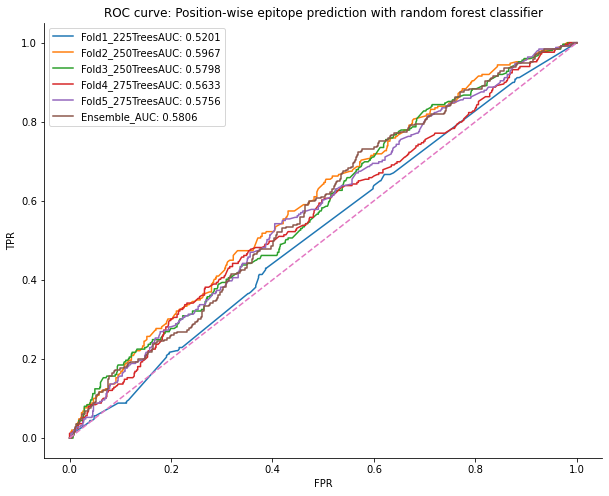

AUC10 0.0725
Accuracy: 0.7432 MCC: -0.0119
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold
Concatenated all model predictions AUC: 0.5647
Concatenated all model predictions AUC10: 0.07246937890064413
Concatenated all model predictions MCC: 0.014979153243538617
Concatenated all model predictions recall 0.0024096385542168677
Concatenated all model predictions precision: 0.42857142857142855
Concatenated all model predictions F1 score: 0.004792332268370608
Concatenated all model predictions accuracy: 0.7433573635427394
Latex format: & 0.565 & 0.072 & 0.015 & 0.002 & 0.429 & 0.005 & 0.743
Average AUC across all models 0.567
Average AUC10 across all models 0.078
Average MCC across all models 0.014
Average positive recall across all models 0.002
Average precision across all models 0.267
Average F1-score across all models 0.005
Average accuracy across all models 0.743


In [21]:

test_annotations = BEPIPRED3_DATA / "6Clusterat50ID" / "2CreateTestSet" / "bepipred3_test.fasta"


### BEPIPRED2 DATASET ###

##One-hot Encoding
test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
              RANDOM_FOREST_CLASSIFICATION / "BepiPred2OneHotEncodedNonHomReduced",
              plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
              one_hot_encode_path = test_annotations,
              accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
###
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred2OneHotEncodedHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             one_hot_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])#


#
##Blosum-62 Encoding
##
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred2BlosumNonHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
#
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred2BlosumHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
#

#### BEPIPRED3 DATASET ###
#
#
## on 5 proteins from BepiPred2 paper test set ##
#
#one-hot encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#             RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedNonHomReduced",
#             plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             one_hot_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
##
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedHomReduced",
#              plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#              one_hot_encode_path = test_annotations,
#              accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
#blosum-62 encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred3BlosumNonHomReduced",
#    plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])#
#
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred3BlosumHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
#
## on 15 proteins including the 5 proteins from the Bepipred2 dataset ##
#
#
#one-hot encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedNonHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#            one_hot_encode_path = test_annotations)
#
##test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
###              RANDOM_FOREST_CLASSIFICATION / "BepiPred3OneHotEncodedHomReduced",
###            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
###             one_hot_encode_path = test_annotations)
###
#####blosum-62 encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred3BlosumNonHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations)
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#              RANDOM_FOREST_CLASSIFICATION / "BepiPred3BlosumHomReduced",
#            plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations)
#

### BEPIPRED3 Test BASELINE PERFORMANCE OF Clustered 50ID ###


## on 5 proteins from BepiPred2 paper test set ##
##one hot encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#               RANDOM_FOREST_CLASSIFICATION / "BepiPred3Clus50IdOneHotEncoded",
#              plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#              one_hot_encode_path = test_annotations,
#             accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
#
##blosum62 encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#             RANDOM_FOREST_CLASSIFICATION / "BepiPred3Clus50IdBlosum",
#             plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#             blosum_encode_path = test_annotations,
#              accs_to_evaluate = ["7lj4_B","4xak_A", "4ypg_D", "7chz_I", "5d8j_A"])
#

# on 15 proteins including the 5 proteins from the Bepipred2 dataset ##
#one hot encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#               RANDOM_FOREST_CLASSIFICATION / "BepiPred3Clus50IdOneHotEncoded",
#              plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#              one_hot_encode_path = test_annotations)
##blosum62 encoding
#test_set_eval(BEPIPRED3_DATA / "6Clusterat50ID" / "5CrossValidationClusterAt50Id" / "test.npz",
#             RANDOM_FOREST_CLASSIFICATION / "BepiPred3Clus50IdBlosum",
#             plot_title = "ROC curve: Position-wise epitope prediction with random forest classifier",
#            blosum_encode_path = test_annotations)

In [62]:

test1 = ['2xwt_C', '3pnw_O', '4qci_D', '4xak_A', '4ypg_D', '5d8j_A', '5f72_K', '5th9_A', '6hga_B', '6u6u_R', '6vtw_A', '6y6c_A', '7chz_I', '7jum_A', '7lj4_B']

test2 = ["7lj4_B", "4xak_A", "4ypg_D", "7chz_I", "5d8j_A"]
#ding =[idx for idx, a in enumerate(test1) for b in test2 if a==b]
ding = [idx for b in test2 for idx, a in enumerate(test1) if a==b]




In [63]:
print(ding)

[14, 3, 4, 12, 5]


In [29]:
test3 = np.asarray([[1,2,3], [1,23,4], [2,6,7]])

In [33]:
test3[[0],[1]]

array([2])

In [36]:
test4 = np.take(test3, [1], axis=0)

In [37]:
print(test4)

[[ 1 23  4]]
